# Example: bayesian optimisation

Employ Bayesian optimisation to determine the parameters in the nonlinear constitutive law

Experimental results for the following example can be found in [1]. 

[1] Grégoire, D., Rojas‐Solano, L. B., & Pijaudier‐Cabot, G. (2013). Failure
and size effect for notched and unnotched concrete beams. International Journal
for Numerical and Analytical Methods in Geomechanics, 37(10), 1434-1452.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab

    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/pypd.git
    print("Package installed successfully")
    import pypd

    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
except ImportError:
    IN_COLAB = False
    import pypd

    print("Not running in Colab")

Not running in Colab


In [2]:
if IN_COLAB:
    try:
        gpu_info = !nvidia-smi
        gpu_info = "\n".join(gpu_info)
        print("GPU Information:")
        print(gpu_info)
    except:
        print("GPU information not available")

    try:
        import multiprocessing

        cpu_info = f"Number of CPU cores: {multiprocessing.cpu_count()}"
        print("\nCPU Information:")
        print(cpu_info)
    except:
        print("CPU information not available")
else:
    print("Not running in Colab.")

Not running in Colab.


### Functions required to build the input file

In [3]:
mm_to_m = 1e-3
m_to_mm = 1e3

In [4]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):  # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

In [5]:
def build_boundary_conditions(particles):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)
    return bc_flag, bc_unit_vector

### Define functions to plot the experimental and numerical load-CMOD response

In [6]:
def load_data_file(filename="half_notched_beam.csv"):
    """
    Determine the location of the example and construct the path to the data
    file dynamically.
    """
    file_path = os.path.join(os.getcwd(), "data", filename)
    return np.genfromtxt(file_path, delimiter=",")

In [7]:
def load_data_file_github(
    filename="https://raw.githubusercontent.com/mark-hobbs/PyPD/main/examples/data/half_notched_beam.csv",
):
    import requests
    import io

    response = requests.get(filename)
    data = np.genfromtxt(io.StringIO(response.text), delimiter=",", skip_header=1)
    return data

In [8]:
def plot_load_cmod(model, n_div_z, fig_title="load-cmod", save_csv=False):
    load = -np.array(model.penetrators[0].penetrator_force_history) * n_div_z
    cmod = np.array(model.observations[1].history) - np.array(
        model.observations[0].history
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_experimental_data(ax)
    ax.plot((cmod[:, 0] * m_to_mm), load[:, 1], label="Numerical")

    ax.set_xlim(0, 0.20)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("CMOD (mm)")
    ax.set_ylabel("Load (N)")
    ax.grid(True)
    ax.legend()

    fig.tight_layout()
    fig.savefig(fig_title, dpi=300)

    if save_csv == True:
        data = [(cmod[:, 0] * m_to_mm), load[:, 1]]
        np.savetxt(
            "load_cmod.csv", np.transpose(np.array(data)), delimiter=",", fmt="%f"
        )

In [9]:
def plot_experimental_data(ax):
    if IN_COLAB:
        data_file = load_data_file_github()
    else:
        data_file = load_data_file()

    cmod = data_file[:, 0]
    load_min = data_file[:, 1]
    load_max = data_file[:, 2]

    grey = (0.75, 0.75, 0.75)
    ax.plot(cmod, load_min, color=grey)
    ax.plot(cmod, load_max, color=grey)
    ax.fill_between(
        cmod,
        load_min,
        load_max,
        color=grey,
        edgecolor=None,
        label="Experimental",
    )

### Build the particles and boundary conditions

In [10]:
dx = 2.5 * mm_to_m
length = 175 * mm_to_m
depth = 50 * mm_to_m
width = 50 * mm_to_m
n_div_x = np.rint(length / dx).astype(int)
n_div_y = np.rint(depth / dx).astype(int)
n_div_z = np.rint(width / dx).astype(int)
notch = [
    np.array([(length * 0.5) + (dx * 0.5), 0]),
    np.array([(length * 0.5) + (dx * 0.5), depth * 0.5]),
]

In [11]:
x = build_particle_coordinates(dx, n_div_x, n_div_y)
flag, unit_vector = build_boundary_conditions(x)  # TODO: not needed

### Build the model

**Note:** Boundary conditions are currently required; however, they should not be mandatory, as this example employs a contact model. This limitation will be addressed in a future update.

In [12]:
material = pypd.Material(name="quasi-brittle", E=37e9, Gf=143.2, density=2346, ft=3.9e6)
bc = pypd.BoundaryConditions(flag, unit_vector, magnitude=0)
particles = pypd.ParticleSet(x, dx, bc, material)

radius = 25 * mm_to_m
penetrators = []
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * length, depth + radius - dx]),
        np.array([0, 1]),
        np.array([0, -0.4 * mm_to_m]),
        radius,
        particles,
        name="Penetrator",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - left",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([3 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - right",
        plot=False,
    )
)

observations = []
observations.append(
    pypd.Observation(
        np.array([77.5 * mm_to_m, 0]), particles, period=1, name="CMOD - left"
    )
)
observations.append(
    pypd.Observation(
        np.array([97.5 * mm_to_m, 0]), particles, period=1, name="CMOD - right"
    )
)

### Visualise the particles and penetrators

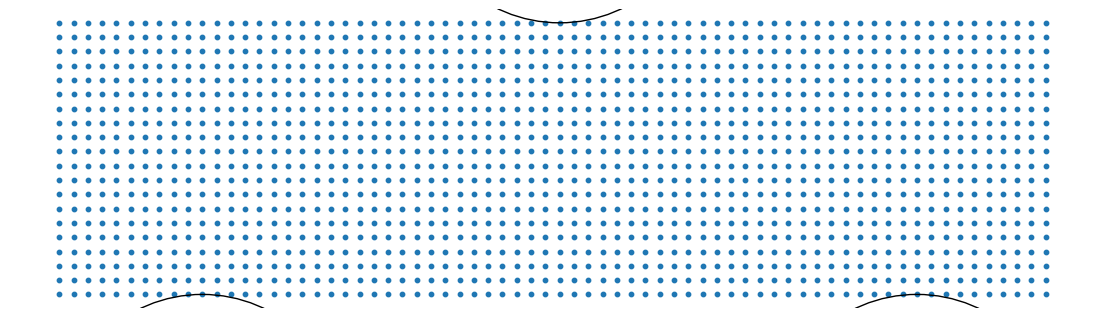

In [13]:
fig, ax = plt.subplots(figsize=(14, 7.5))
ax.scatter(particles.x[:, 0], particles.x[:, 1], s=10)
ax.axis("off")
ax.set_aspect("equal")
for penetrator in penetrators:
    penetrator.plot(ax=ax)

### Objective function

The goal is to determine the values of `alpha` and `k` that minimise the difference between the experimental and numerical results.

In [14]:
def objective(model):
    """
    Mean Square Error (MSE)
    """
    if IN_COLAB:
        data_file = load_data_file_github()
    else:
        data_file = load_data_file()

    cmod = data_file[:, 0]
    load_min = data_file[:, 1]
    load_max = data_file[:, 2]
    load_mean = (load_max + load_min) / 2

    load_model = -np.array(model.penetrators[0].penetrator_force_history) * n_div_z
    cmod_model = np.array(model.observations[1].history) - np.array(model.observations[0].history)
    
    load_model_interp = np.interp(cmod, cmod_model[:, 0] * m_to_mm, load_model[:, 1])    
    return np.mean(np.nan_to_num(load_model_interp - load_mean, nan=0) ** 2)

### Design of experiments (DOE)

Run 10 simulations with random samples of `alpha` and `k`

In [15]:
import copy

In [16]:
simulation = pypd.Simulation(n_time_steps=100000, damping=0)

results = []
n_samples = 50
for i in range(n_samples):
    alpha = np.random.uniform(0, 1)
    k = np.random.uniform(0, 500)
    bonds = pypd.BondSet(copy.deepcopy(particles),
                         constitutive_law=pypd.NonLinear, 
                         constitutive_law_params={'alpha': alpha, 'k': k},
                         surface_correction=True, 
                         notch=notch)
    model = pypd.Model(copy.deepcopy(particles), 
                       bonds, 
                       penetrators=copy.deepcopy(penetrators), 
                       observations=copy.deepcopy(observations))
    simulation.run(model)
    mse = float(objective(model))
    
    print(f"\nSample {i}")
    print(f"alpha : {alpha}, k : {k}, MSE : {mse}\n")
    results.append((alpha, k, mse))

print(results)

/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator
Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3162.04steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 0
alpha : 0.15677110305248532, k : 36.72010972822981, MSE : 30387.398046185484



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:26<00:00, 3724.57steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 1
alpha : 0.01833770239785537, k : 78.56989436727557, MSE : 65878.35442635062



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3686.34steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 2
alpha : 0.19907260526257453, k : 203.31551475587133, MSE : 2859.3739190461697



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3595.17steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 3
alpha : 0.8550817762494654, k : 451.562399353915, MSE : 330859.54208771756



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:26<00:00, 3723.67steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 4
alpha : 0.9324225484799761, k : 311.4847208544405, MSE : 367143.8012814101



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3629.40steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 5
alpha : 0.9710299233959526, k : 63.19154528806115, MSE : 305608.99356674595



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3612.35steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 6
alpha : 0.5389527763727607, k : 196.93280511009732, MSE : 128605.4744470033



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3636.41steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 7
alpha : 0.9331835720965179, k : 386.4561626544949, MSE : 373693.1657810715



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3566.60steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 8
alpha : 0.9582954705066812, k : 277.27264789680726, MSE : 378082.6497418901



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3654.69steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 9
alpha : 0.8348786557700862, k : 6.4801418855819914, MSE : 236967.37561239573



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:26<00:00, 3710.18steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 10
alpha : 0.6539875495389917, k : 95.10224299714653, MSE : 175679.8777048266



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3562.99steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 11
alpha : 0.39923101339850586, k : 391.0206805125926, MSE : 61453.376524074316



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3654.36steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 12
alpha : 0.6831048533466829, k : 387.2019555230521, MSE : 222956.91792917522



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3628.99steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 13
alpha : 0.9246097661352112, k : 488.5346467585064, MSE : 374167.0453471674



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3614.68steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 14
alpha : 0.6793360776663663, k : 106.5830970984219, MSE : 191550.82509563147



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3675.64steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 15
alpha : 0.9753350429864198, k : 396.66552734839195, MSE : 398810.84680388373



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3641.31steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 16
alpha : 0.9625102334268789, k : 273.11997609192355, MSE : 379927.6895437732



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3571.08steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 17
alpha : 0.36036066718638327, k : 303.6117592912624, MSE : 43365.55596989323



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3543.25steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 18
alpha : 0.36633383780467554, k : 58.3259898918147, MSE : 50608.35944521137



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:26<00:00, 3719.68steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 19
alpha : 0.5185145306839195, k : 237.56147001907775, MSE : 119671.95328200128



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3532.07steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 20
alpha : 0.953345228075665, k : 440.3123321068098, MSE : 388739.20971559756



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3075.54steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 21
alpha : 0.24517072252195982, k : 344.77139820288323, MSE : 8372.55040666532



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3032.95steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 22
alpha : 0.4761102360652195, k : 176.13867322566128, MSE : 94503.25072403283



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3139.77steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 23
alpha : 0.015881400687910552, k : 306.65815709609365, MSE : 25598.050198611247



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3585.35steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 24
alpha : 0.491300802666609, k : 422.9077200169836, MSE : 109665.24985039374



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3653.32steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 25
alpha : 0.4945492680069893, k : 400.11018419406975, MSE : 111087.34107104196



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:34<00:00, 2916.25steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 26
alpha : 0.12135952353069246, k : 449.6762122652236, MSE : 14842.77915558306



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:36<00:00, 2775.88steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 27
alpha : 0.8930363099195172, k : 358.7148566095419, MSE : 348223.30383412144



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:33<00:00, 3000.26steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 28
alpha : 0.37795856945143236, k : 255.37905360732333, MSE : 50315.13534684483



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3126.41steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 29
alpha : 0.7172167748720057, k : 486.4595565417728, MSE : 247440.8316378732



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:35<00:00, 2814.86steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 30
alpha : 0.2402661662129626, k : 243.918948495551, MSE : 7323.919181834466



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:34<00:00, 2878.44steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 31
alpha : 0.027790146373289804, k : 110.78188496132424, MSE : 29879.264938073047



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:33<00:00, 3006.77steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 32
alpha : 0.24609914139276634, k : 361.82258617048404, MSE : 8581.536577327366



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3257.83steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 33
alpha : 0.20298887635414742, k : 54.65658515182786, MSE : 16003.819415043137



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3032.76steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 34
alpha : 0.811218022609856, k : 237.4417232027417, MSE : 288874.7967953714



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:34<00:00, 2880.84steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 35
alpha : 0.7031697042667356, k : 388.67946451287713, MSE : 235317.4873663564



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:33<00:00, 2976.27steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 36
alpha : 0.9807638612766959, k : 108.21162913278137, MSE : 344889.1410754996



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3101.84steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 37
alpha : 0.6516184507645103, k : 379.2850846647887, MSE : 203397.54305257904



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3187.46steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 38
alpha : 0.6005867963090188, k : 477.59068521041155, MSE : 175063.8993995643



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3152.45steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 39
alpha : 0.034815662142142934, k : 400.9604063113001, MSE : 38948.56332467882



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3580.78steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 40
alpha : 0.34590991262329485, k : 108.80704789549628, MSE : 37443.0913708945



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3600.16steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 41
alpha : 0.9779887792375843, k : 378.3028865605384, MSE : 399025.7305775399



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3600.70steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 42
alpha : 0.6816968092812121, k : 191.97363562361036, MSE : 208288.34119990788



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3082.24steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 43
alpha : 0.25572395388647207, k : 39.793772833497556, MSE : 34686.185099742506



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3189.93steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 44
alpha : 0.5922084215138533, k : 264.528253071671, MSE : 162682.51164079647



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3276.37steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 45
alpha : 0.6793368955375724, k : 75.86261973708652, MSE : 182186.72462729685



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3223.80steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 46
alpha : 0.4282324994870216, k : 394.5488020886137, MSE : 75732.7970267841



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3323.79steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 47
alpha : 0.9714081805390279, k : 33.02402081390326, MSE : 265653.94684203994



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3301.21steps/s]
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator



Sample 48
alpha : 0.2596650805234729, k : 429.34477769518674, MSE : 11371.062624077385



Simulation progress: 100%|██████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3573.26steps/s]



Sample 49
alpha : 0.6578653987381894, k : 230.5357060602709, MSE : 198549.13865363854

[(0.15677110305248532, 36.72010972822981, 30387.398046185484), (0.01833770239785537, 78.56989436727557, 65878.35442635062), (0.19907260526257453, 203.31551475587133, 2859.3739190461697), (0.8550817762494654, 451.562399353915, 330859.54208771756), (0.9324225484799761, 311.4847208544405, 367143.8012814101), (0.9710299233959526, 63.19154528806115, 305608.99356674595), (0.5389527763727607, 196.93280511009732, 128605.4744470033), (0.9331835720965179, 386.4561626544949, 373693.1657810715), (0.9582954705066812, 277.27264789680726, 378082.6497418901), (0.8348786557700862, 6.4801418855819914, 236967.37561239573), (0.6539875495389917, 95.10224299714653, 175679.8777048266), (0.39923101339850586, 391.0206805125926, 61453.376524074316), (0.6831048533466829, 387.2019555230521, 222956.91792917522), (0.9246097661352112, 488.5346467585064, 374167.0453471674), (0.6793360776663663, 106.5830970984219, 191550.8250956314

### Save and visualise results

In [21]:
import csv
save = False

if save:
    with open('results.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["alpha", "k", "MSE"])
        writer.writerows(results)

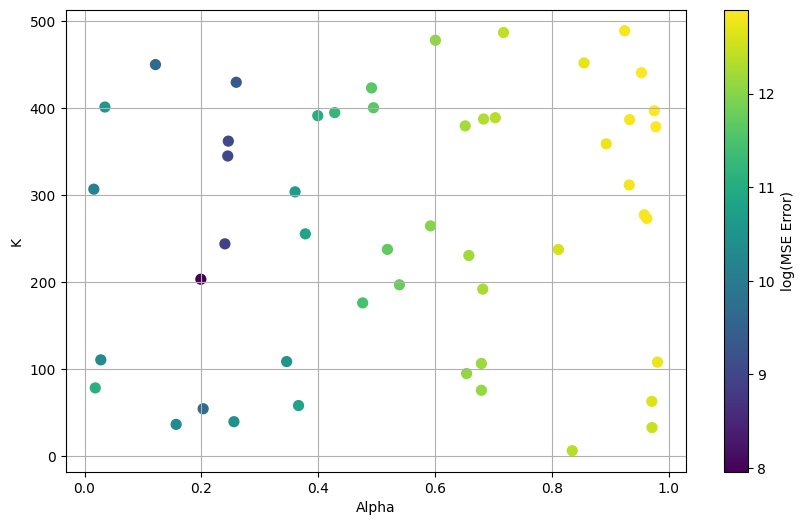

In [18]:
# results = load_data_file("bayesian-optimisation.csv")

samples = np.array(results)
# samples = samples[1:] # remove headings

plt.figure(figsize=(10, 6))
scatter = plt.scatter(samples[:, 0], samples[:, 1], c=np.log(samples[:, 2]), cmap='viridis', s=50)
plt.colorbar(scatter, label='log(MSE Error)')
plt.xlabel('Alpha')
plt.ylabel('K')
plt.grid(True)

### Fit a Gaussian Process (GP)

In [19]:
import GPy

X = samples[:, :2]
Y = np.log(samples[:, 2].reshape(-1, 1))

kernel = GPy.kern.RBF(input_dim=2, ARD=True)

gp = GPy.models.GPRegression(X, Y, kernel)
gp.optimize(messages=True)

 /Users/markhobbs/.local/share/virtualenvs/pypd-EEdp8jsB/lib/python3.11/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/markhobbs/.local/share/virtualenvs/pypd-EEdp8jsB/lib/python3.11/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/markhobbs/.local/share/virtualenvs/pypd-EEdp8jsB/lib/python3.11/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


### Fitted GP

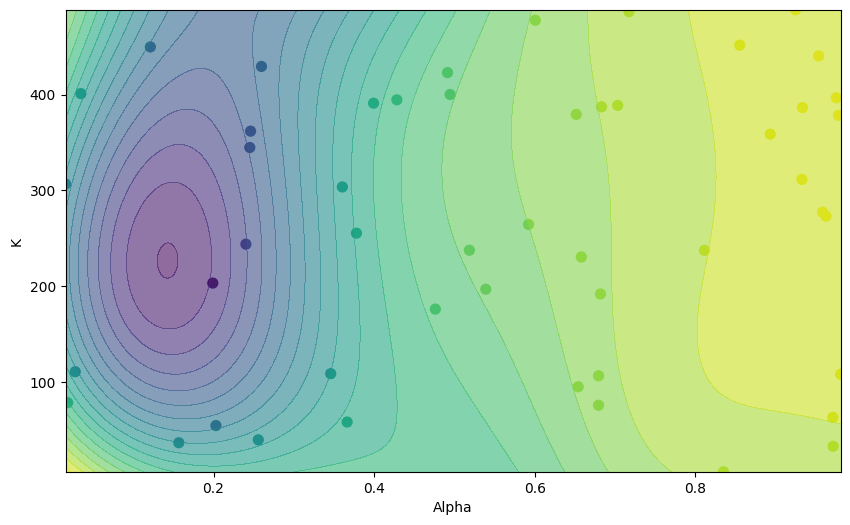

In [20]:
alpha_grid, k_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 1000),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 1000)
)
X_pred = np.column_stack([alpha_grid.ravel(), k_grid.ravel()])

mean, variance = gp.predict(X_pred)
mean = mean.reshape(alpha_grid.shape)
variance = variance.reshape(alpha_grid.shape)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(samples[:, 0], samples[:, 1], c=np.log(samples[:, 2]), cmap='viridis', s=50)
plt.xlabel('Alpha')
plt.ylabel('K')

contour = plt.contourf(alpha_grid, k_grid, mean, levels=20, cmap='viridis', alpha=0.6)